In [ ]:
# !pip install transformers
# !pip install emoji
# !pip install sentencepiece 

     |████████████████████████████████| 2.6 MB 11.0 MB/s 
     |████████████████████████████████| 895 kB 40.6 MB/s 
     |████████████████████████████████| 3.3 MB 35.0 MB/s 
     |████████████████████████████████| 636 kB 44.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 184 kB 10.8 MB/s 
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=b30bb465f9be6f07ffdced1433169605588a45dedc94528abd9eb7aa1e10cf96
  Stored in directory: /root/.cache/pip/wheels/e4/61/e7/2fc1ac8f306848fc66c6c013ab511f0a39ef4b1825b11363b2
Successfully built emoji
     |████████████████████████████████| 1.2 MB 10.5 MB/s 


In [ ]:
import torch
import json
import random
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
import re
import numpy as np
import emoji
from transformers import *
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import accuracy_score,f1_score
from sklearn.utils.class_weight import compute_class_weight
#from transformers import LongformerTokenizer, LongformerForSequenceClassification
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from sklearn.metrics import *


# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name())

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
from transformers import *

In [ ]:
params={
    'max_length':256,
    'path_files': 'Hate-speech-CNERG/dehatebert-mono-arabic',
    'what_bert':'weighted',
    'batch_size':24,
    'is_train':True,
    'learning_rate':2e-5,
    'epsilon':1e-8,
    'random_seed':30,
    'epochs':1,
    'to_save':True,
    'weights':[0.1785,0.8215],
    'frac':0.8
}

In [ ]:
def Diff(a,b):
    return list(set(a) -set(b))

def re_sub(pattern, repl,text):
    return re.sub(pattern, repl, text)


def preprocess_sent(sent):
    sent = re.sub(r"http\S+", "", sent)
    sent = re.sub(r"@\S+", "@user", sent)

    #print(sent)
    sent = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "",sent)
    sent = emoji.demojize(sent)
    sent = re_sub(r"[:\*]", " ",sent)
    return sent

def evalMetric(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    mf1Score = f1_score(y_true, y_pred, average='macro')
    f1Score  = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    area_under_c = auc(fpr, tpr)
    recallScore = recall_score(y_true, y_pred)
    precisionScore = precision_score(y_true, y_pred)
    return {"accuracy": accuracy, 'mF1Score': mf1Score, 'f1Score': f1Score, 'auc': area_under_c, 
            'precision': precisionScore, 'recall': recallScore}


#Creating an attention mask - For actual tokens its set to 1, for padding tokens its set to 0
def create_attention_masks(input_ids):
    attention_masks = []
    for seq in tqdm(input_ids):
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return np.array(attention_masks)

def getFeaturesandLabel(X,y):
    sentences = list(X)
    sentences = ["[CLS] "+ i + " [SEP]"for i in sentences]
    tokenizer_texts = list(map(lambda t: tokenizer.tokenize(t)[:512], tqdm(sentences)))
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenizer_texts)]
    input_ids = pad_sequences(sequences = input_ids, maxlen = param['maxLen'], dtype = 'long', padding='post', truncating='post')
    attention_masks_data = create_attention_masks(input_ids)
    X_data = torch.tensor(input_ids)
    attention_masks_data = torch.tensor(attention_masks_data)
    y_data = torch.tensor(y)
    return X_data, attention_masks_data, y_data


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import pandas as pd
trainData = pd.read_csv("/content/drive/MyDrive/UrduThreat/train.csv")

In [ ]:
X, y  = list(trainData['tweet']), list(trainData['target'])

In [ ]:
sum(y)/len(y)

0.1785

In [ ]:
from sklearn.model_selection import train_test_split

# given:
# features: xs
# ground truth: ys

#X_tn, X_v, y_tn, y_v = train_test_split(X, y, test_size=0.15, random_state=2021, stratify=y)

In [ ]:
X_tn , y_tn = X, y

In [ ]:

test = pd.read_csv("/content/drive/MyDrive/UrduThreat/test.csv")


# In[9]:


X_ts = list(test['tweet'])
y_ts = [0] *len(X_ts)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('Hate-speech-CNERG/dehatebert-mono-arabic', do_lower_case = True)

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/152 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

In [ ]:
param ={
    'maxLen' :256,
}


In [ ]:
X_train, attention_masks_train, y_train = getFeaturesandLabel(X_tn,y_tn)
#X_val, attention_masks_val, y_val = getFeaturesandLabel(X_v,y_v)
X_test, attention_masks_test, y_test = getFeaturesandLabel(X_ts,y_ts)

100%|██████████| 3950/3950 [00:00<00:00, 5430.69it/s]


In [ ]:
BATCH_SIZE = 24
#Dataset wrapping tensors.
train_data = TensorDataset(X_train, attention_masks_train, y_train)
#val_data = TensorDataset(X_val, attention_masks_val, y_val)
test_data = TensorDataset(X_test, attention_masks_test, y_test)

#Samples elements randomly. If without replacement(default), then sample from a shuffled dataset.
train_sampler = RandomSampler(train_data)
#val_sampler = SequentialSampler(val_data)
test_sampler = SequentialSampler(test_data)

#represents a Python iterable over a dataset
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = BATCH_SIZE)
#validation_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = BATCH_SIZE)


In [ ]:
# Class for weighted bert for sentence classification
class SC_weighted_BERT(BertPreTrainedModel):
    def __init__(self, config,weights):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.weights=weights
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(self.weights).cuda())
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [ ]:
def select_model(type_of_model,path,weights=None,label_list=None):
    if(type_of_model=='weighted'):
        model = SC_weighted_BERT.from_pretrained(
        path, # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels--2 for binary classification             # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        weights=weights
    )
    else:
        print("Error in model name!!!!")
    return model

In [ ]:
import torch
import torch.nn as nn

In [ ]:
model = select_model(params['what_bert'], params['path_files'], params['weights'])

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [ ]:
import numpy as np
def getProb(temp):
    t = np.exp(temp)
    return t[1]/(sum(t))


In [ ]:
def getPerformanceOfLoader(test_dataloader):
    model.eval()
    # Tracking variables 
    predictions , true_labels = [], []
    # Predict 
    for batch in test_dataloader:
    #print(batch)
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
  
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Store predictions and true labels
        predictions.extend(logits)
        true_labels.extend(label_ids)

    print('DONE.')
    predict =[]
    proba = []
    for i in predictions:
        if i[0]>= i[1]:
            predict.append(0)
        else:
            predict.append(1)
        proba.append(getProb(i))

    df = pd.DataFrame()
    df['id']=test['id']
    df['target'] = predict
    df['score'] = proba
    return df

In [ ]:
# Tell pytorch to run this model on the GPU.
model.cuda()

bestValAcc  = 0
besttest_df  = None

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

epochs = 10
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
loss_values = []

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader) 

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    # print("Running Validation...")

    # t0 = time.time()

    # # Put the model in evaluation mode--the dropout layers behave differently
    # # during evaluation.
    # model.eval()

    # # Tracking variables 
    # eval_loss, eval_accuracy = 0, 0
    # nb_eval_steps, nb_eval_examples = 0, 0
 
    # # Evaluate data for one epoch
    # for batch in validation_dataloader:
        
    #     # Add batch to GPU
    #     batch = tuple(t.to(device) for t in batch)
        
    #     # Unpack the inputs from our dataloader
    #     b_input_ids, b_input_mask, b_labels = batch
        
    #     # Telling the model not to compute or store gradients, saving memory and
    #     # speeding up validation
    #     with torch.no_grad():        

    #         # Forward pass, calculate logit predictions.
    #         # This will return the logits rather than the loss because we have
    #         # not provided labels.
    #         # token_type_ids is the same as the "segment ids", which 
    #         # differentiates sentence 1 and 2 in 2-sentence tasks.
    #         # The documentation for this `model` function is here: 
    #         # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    #         outputs = model(b_input_ids, 
    #                         token_type_ids=None, 
    #                         attention_mask=b_input_mask)
        
    #     # Get the "logits" output by the model. The "logits" are the output
    #     # values prior to applying an activation function like the softmax.
    #     logits = outputs[0]

    #     # Move logits and labels to CPU
    #     logits = logits.detach().cpu().numpy()
    #     label_ids = b_labels.to('cpu').numpy()

    #     # Calculate the accuracy for this batch of test sentences.
    #     tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
    #     # Accumulate the total accuracy.
    #     eval_accuracy += tmp_eval_accuracy

    #     # Track the number of batches
    #     nb_eval_steps += 1

    # # Report the final accuracy for this validation run.
    # if ((eval_accuracy/nb_eval_steps) > bestValAcc):
    #      bestValAcc  = eval_accuracy/nb_eval_steps
    #      besttest_df = getPerformanceOfLoader(test_dataloader)
    # print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    # print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...


KeyboardInterrupt: ignored

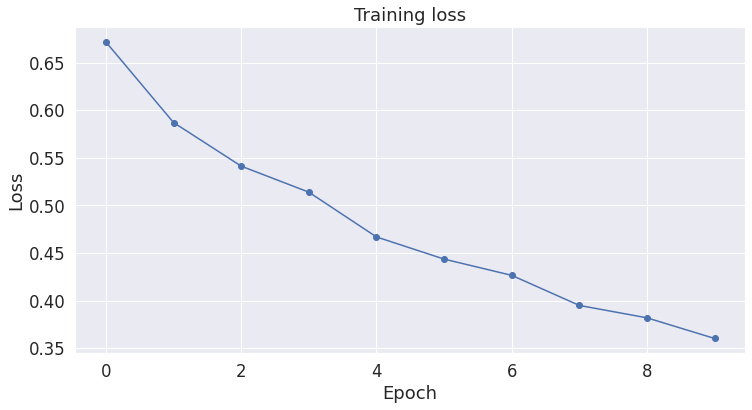

In [ ]:
import matplotlib.pyplot as plt
#%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:

# Prediction on test set

#print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
    #print(batch)
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    # Store predictions and true labels
    predictions.extend(logits)
    true_labels.extend(label_ids)

print('DONE.')

DONE.


In [ ]:
import numpy as np
def getProb(temp):
    t = np.exp(temp)
    return t[1]/(sum(t))


In [ ]:
predict =[]
proba = []
for i in predictions:
    if i[0]>= i[1]:
        predict.append(0)
    else:
        predict.append(1)
    proba.append(getProb(i))

df = pd.DataFrame()
df['id']=test['id']
df['target'] = predict
df['score'] = proba

In [ ]:
df = pd.DataFrame()
df['id']=test['id']
df['target'] = predict
df['score'] = proba

In [ ]:
df.to_csv("/content/drive/MyDrive/UrduThreat/mBERT_final_ThreatAll.csv")

In [ ]:
df.to_csv("mBERT_final_ThreatAll.csv")

In [ ]:
besttest_df.to_csv("/content/drive/MyDrive/UrduThreat/mBERT_arabic_best_threat24.csv")

In [ ]:
besttest_df.head()

,id,target,score
0,8980,0,0.005346
1,3784,0,0.001315
2,8312,0,0.229421
3,9932,1,0.993588
4,150,0,0.299627


In [ ]:
df.head()

,id,target,score
0,8980,0,0.000703
1,3784,0,0.000746
2,8312,0,0.024800
3,9932,1,0.997972
4,150,0,0.002978


In [ ]:
sum(df['target'])

903